In [11]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 6.8 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [14]:
from tqdm import tqdm

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

import re
import bs4

import spacy
from spacy import displacy
nlp=spacy.load('en_core_web_sm')
from spacy.matcher import Matcher 
from spacy.tokens import Span 

In [38]:
spacy.__version__

'3.5.3'

In [2]:
user_persona = pd.read_json("../data/tech_career_track.json")
user_persona.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   career track    6 non-null      object
 1   attribute 1     6 non-null      object
 2   attribute 2     6 non-null      object
 3   attribute 3     6 non-null      object
 4   special traits  6 non-null      object
 5   tech or stack   6 non-null      object
dtypes: object(6)
memory usage: 416.0+ bytes


In [3]:
user_persona

,career track,attribute 1,attribute 2,attribute 3,special traits,tech or stack
0,front-end developer,creative,problem solver,logical thinker,,"[frontend, html, css, javascript]"
1,back-end developer,logical thinker,problem solver,analytical,,"[backend, database, python, nodejs]"
2,machine learning / data scientist,analytical,problem solver,data-driven,mathematical inclined,"[data, data-science, machine-learning, python]"
3,cloud developer,problem solver,logical thinker,analytical,infrastructure,"[cloud, devops, microservice, architecture]"
4,mobile developer,creative,problem solver,user-focused,tech-savvy,"[mobile, multiplatform, android, ios]"
5,ui/ux designer,creative,analytics,user-focused,empathetic,"[figma, research, mockup, wireframe]"


user persona

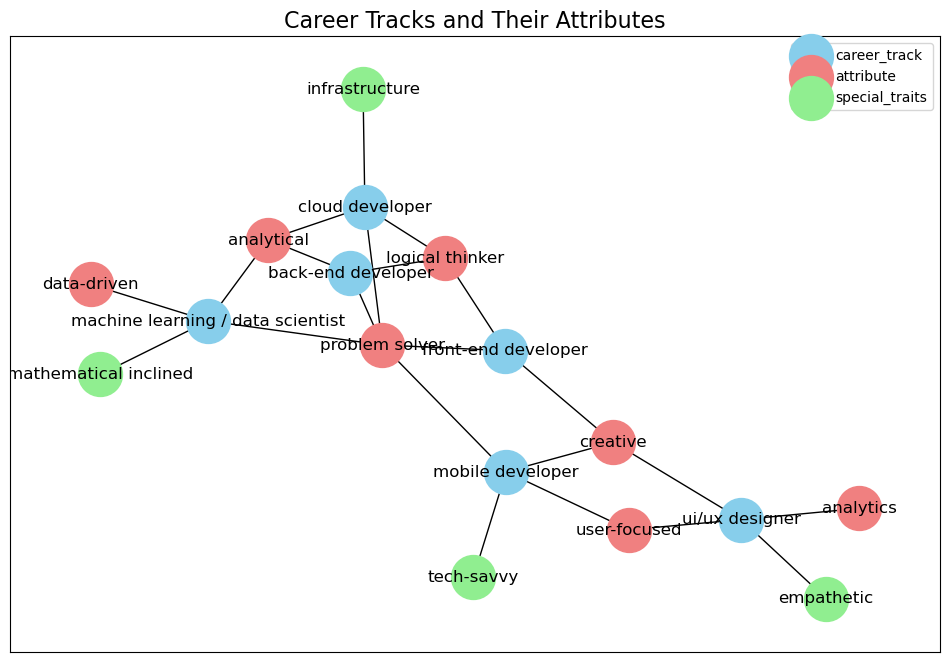

In [6]:
# Create a Pandas DataFrame from the JSON data
df = pd.DataFrame(user_persona.copy())

# Create a graph
G = nx.Graph()

# Add nodes (career tracks) to the graph
for career_track in df["career track"]:
    G.add_node(career_track, type="career_track")

# Add nodes (attributes) to the graph and connect them to career tracks
for index, row in df.iterrows():
    career_track = row["career track"]
    attributes = row[["attribute 1", "attribute 2", "attribute 3"]]
    special_traits = row["special traits"]
    for attribute in attributes:
        G.add_node(attribute, type="attribute")
        G.add_edge(career_track, attribute)
    if special_traits:
        G.add_node(special_traits, type="special_traits")
        G.add_edge(career_track, special_traits)

# Define node colors based on node types
node_colors = {
    "career_track": "skyblue",
    "attribute": "lightcoral",
    "special_traits": "lightgreen",
}

# Draw the graph with specified node colors
pos = nx.spring_layout(G)
plt.figure(figsize=(12, 8))

for node_type, color in node_colors.items():
    nodes = [node for node, data in G.nodes(data=True) if data["type"] == node_type]
    nx.draw_networkx_nodes(G, pos, nodelist=nodes, node_size=1000, node_color=color, label=node_type)

nx.draw_networkx_edges(G, pos)
nx.draw_networkx_labels(G, pos)

plt.title("Career Tracks and Their Attributes", fontsize=16)
plt.legend(loc="upper right")
plt.show()


career persona

In [8]:
career_persona = pd.read_json("../data/career_persona.json")
career_persona

,question,trait,answer
0,1,creative,They would describe me as someone with an imag...
1,1,creative,Friends and family often see me as a creative ...
2,1,creative,They might describe me as the family's creativ...
3,1,creative,My loved ones often label me as a creative ind...
4,1,creative,I'm often seen as the creative spark in our fa...
5,1,creative,"They'd likely describe me as a visionary, know..."
6,1,creative,People who know me well see me as a creative f...
7,2,creative,I'd choose a class that nurtures my artistic t...
8,2,creative,"A creative writing class would be my top pick,..."
9,2,creative,I'd enroll in a filmmaking class to channel my...


In [28]:
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  #############################################################
  
  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  #############################################################

  return [ent1.strip(), ent2.strip()]

In [29]:
get_entities(career_persona.iloc[0,2])

['They', 'innovative  ideas']

In [39]:
import spacy
from spacy.matcher import Matcher

# Load the spaCy language model
nlp = spacy.load("en_core_web_sm")

def get_relation(sent):
    doc = nlp(sent)

    # Matcher class object
    matcher = Matcher(nlp.vocab)

    # Define the pattern
    pattern = [{'DEP':'ROOT'},
               {'DEP':'prep','OP':"?"},
               {'DEP':'agent','OP':"?"},  
               {'POS':'ADJ','OP':"?"}] 

    matcher.add("matching_1", [pattern])  # Note the change here

    matches = matcher(doc)
    k = len(matches) - 1

    span = doc[matches[k][1]:matches[k][2]] 

    return span.text


In [40]:
relations = [get_relation(i) for i in tqdm(career_persona.answer)]
relations






  0%|          | 0/27 [00:00<?, ?it/s]




 48%|████▊     | 13/27 [00:00<00:00, 124.95it/s]




100%|██████████| 27/27 [00:00<00:00, 120.93it/s]


['describe',
 'see',
 'describe',
 'label',
 'seen as',
 'describe',
 'see',
 'choose',
 'be',
 'enroll in',
 'be perfect',
 'opt for',
 'inspire',
 'drawn to',
 'appeal to',
 'find',
 "'m",
 'Tasks',
 'Tasks',
 'Tasks',
 'see',
 'is in creative',
 'contribute',
 'lies in creative',
 'envision',
 'excel in',
 'shine in']

In [22]:
career_persona['answer']

0     They would describe me as someone with an imag...
1     Friends and family often see me as a creative ...
2     They might describe me as the family's creativ...
3     My loved ones often label me as a creative ind...
4     I'm often seen as the creative spark in our fa...
5     They'd likely describe me as a visionary, know...
6     People who know me well see me as a creative f...
7     I'd choose a class that nurtures my artistic t...
8     A creative writing class would be my top pick,...
9     I'd enroll in a filmmaking class to channel my...
10    An improvisation acting class would be perfect...
11    I'd opt for a graphic design class to refine m...
12    An art history class would inspire my creative...
13    I'm most drawn to tasks that involve brainstor...
14    Tasks that require creative problem-solving an...
15    I find tasks involving experimentation and inn...
16    I'm most interested in tasks that challenge me...
17    Tasks that require me to ideate, design, a

In [42]:
pd.Series(relations).value_counts()

describe            3
Tasks               3
see                 3
appeal to           1
excel in            1
envision            1
lies in creative    1
contribute          1
is in creative      1
'm                  1
find                1
drawn to            1
inspire             1
opt for             1
be perfect          1
enroll in           1
be                  1
choose              1
seen as             1
label               1
shine in            1
Name: count, dtype: int64

In [43]:

entity_pairs = []

for i in tqdm(career_persona["answer"]):
  entity_pairs.append(get_entities(i))






  0%|          | 0/27 [00:00<?, ?it/s]




100%|██████████| 27/27 [00:00<00:00, 137.35it/s]


In [44]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

In [51]:
kg_df

,source,target,edge
0,They,innovative ideas,describe
1,creative who,fresh situation,see
2,They,new myself,describe
3,I,everything,label
4,I,inventive challenges,seen as
5,They,creative realities,describe
6,who,unique perspective,see
7,that,artistic painting,choose
8,top me,imaginative storytelling,be
9,I,visual storytelling,enroll in


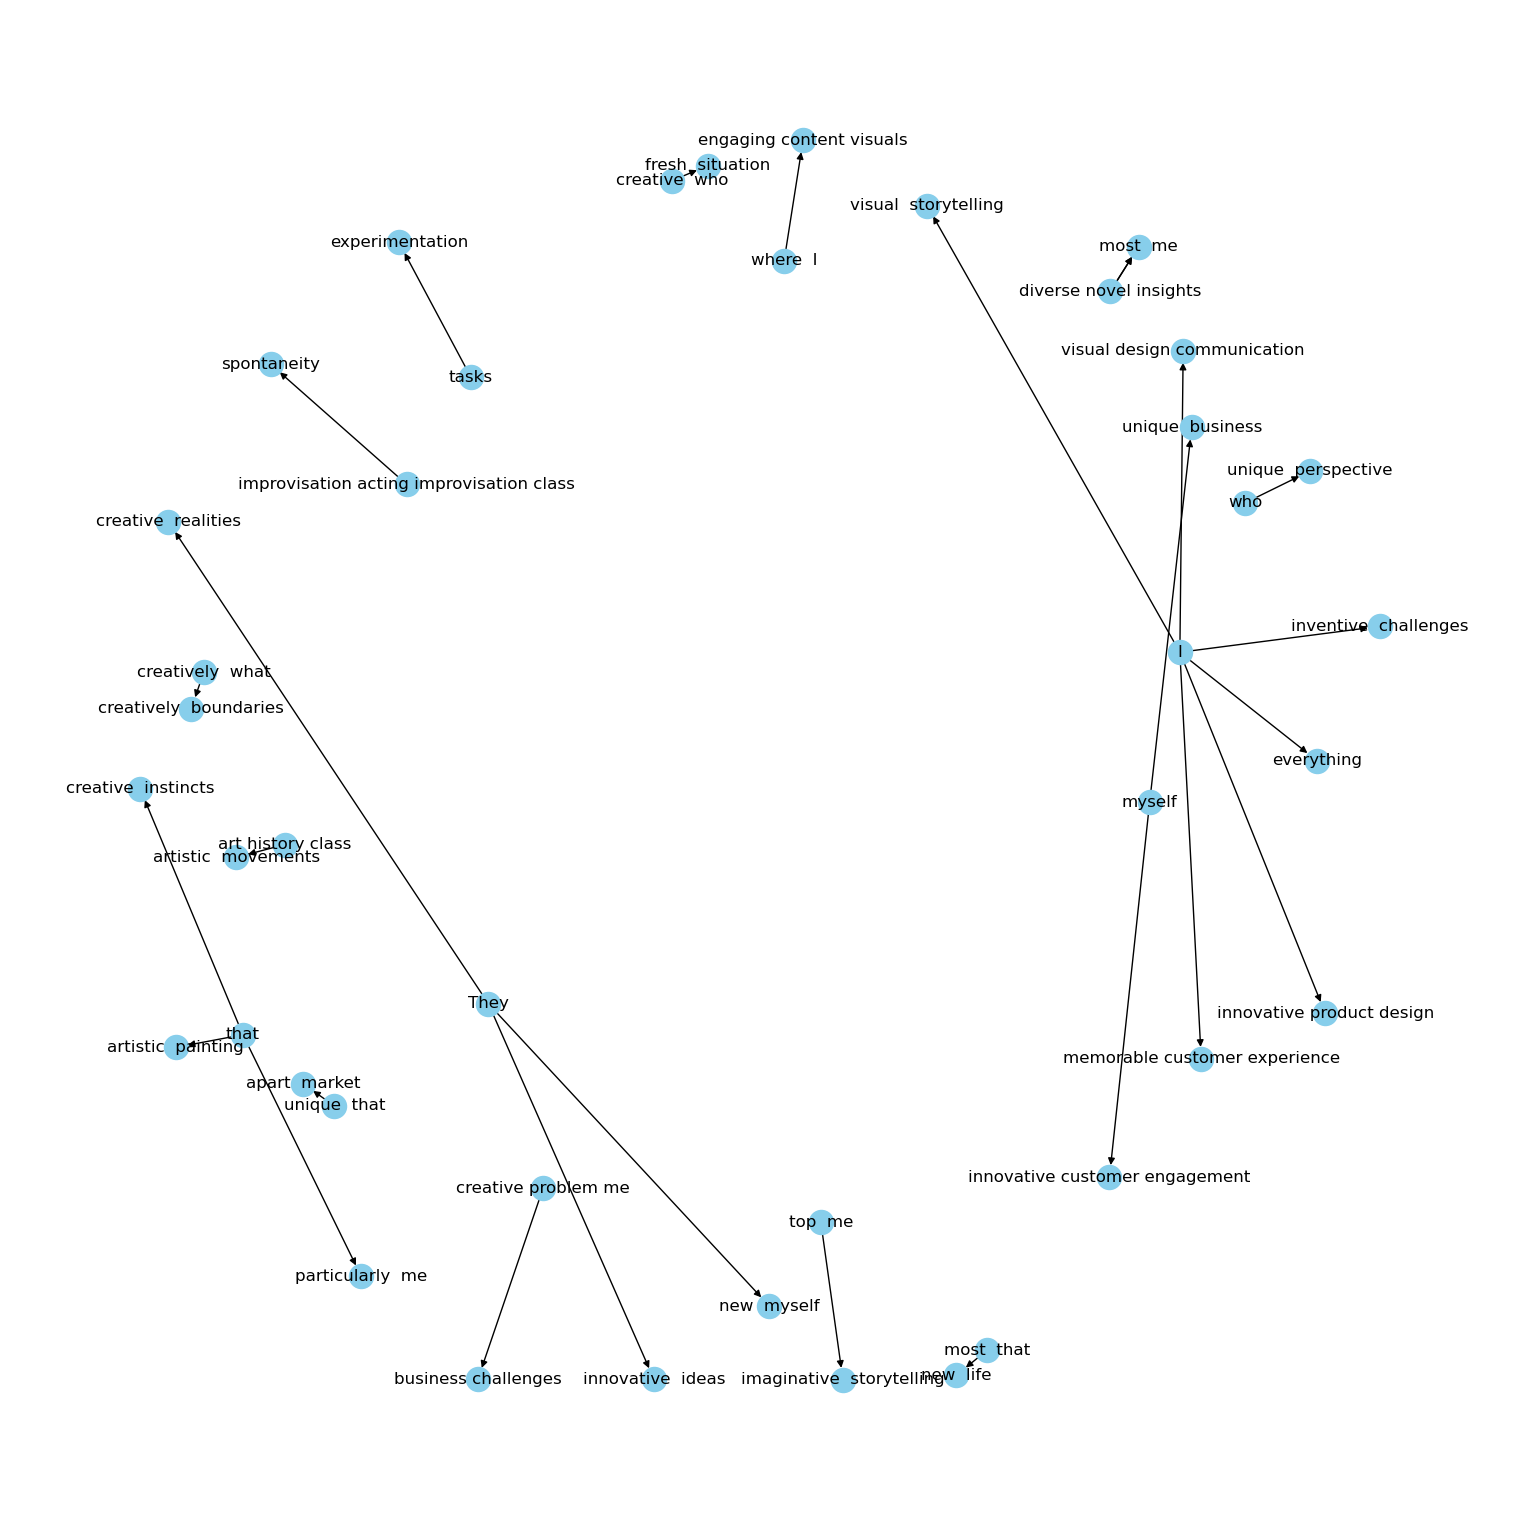

In [50]:
# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())
plt.figure(figsize=(15,15))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()